In [ ]:
from allennlp.commands.elmo import ElmoEmbedder
import numpy as np
import json
import random
import gensim.models.keyedvectors as word2vec
import scipy


In [1]:
#load the word vectors and Elmo embedder
word_vectors = word2vec.KeyedVectors.load_word2vec_format(
            'GoogleNews-vectors-negative300.bin', binary=True)

elmo = ElmoEmbedder()

In [4]:
#Take a sentence and embed it to a single vector by concatenating together different averages
#From "Concatenated Power Mean Embeddings as Universal Cross-Lingual Sentence Representations"
#Ruckle, Andreas and Eger, Steffen and Peyrard, Maxime and Gurevych, Iryna
def sentence_vec(sent,norms=[-np.inf,np.inf,1,2]):
    s = []
    for p in norms:
        if p == -np.inf:
            avg = np.ones_like(sent[0])*99999999999.0
            
            for v in sent:
                pts = np.abs(v) < np.abs(avg)
                avg[pts] = v[pts]
        
        elif p == np.inf:
            avg = np.zeros_like(sent[0])
            
            for v in sent:
                pts = np.abs(v) > np.abs(avg)
                avg[pts] = v[pts]
        else:
            avg = 0
            for v in sent:
                avg += np.power(v,p)

            avg = np.power((avg/len(sent)),(1.0/p))
        s.append(avg)
        
    return np.hstack(s)


In [6]:
#Load in the plotto conflicts
with open('plottoconflicts.json') as infile:
    plotto = json.load(infile)
#Load in a list of first names
with open('firstNames.json') as data_file:
    first_names = json.load(data_file)
    
#Go through the plotto conflicts and put place-holder names in
first_names = first_names['firstNames']
all_sentences = []
for p in plotto['states']:
    state = plotto['states'][p]
    if len(state) > 1:
        text = []
        for s in state:
            text.append(s['text'])
        
        text = ' '.join(text).replace('  ',' ')
        
        for entity in ['A-2','A-3','A-4','A-5','A-6','A-7','A-8','A-9',
                       'B-1','B-2','B-3','B-4','B-5','B-6','B-7','B-8','B','$A$']:
            text = text.replace(entity,random.choice(first_names))
        all_sentences.append(text.split(' '))
        
print(all_sentences[0])

['Paul,', 'a', 'cashier', 'responsible', 'for', 'the', 'funds', 'of', 'the', 'firm', 'employing', 'him,', 'is', 'ordered', 'by', 'Damian', ',', 'junior', 'partner', 'of', 'the', 'firm,', 'to', 'give', 'him', 'secretly', 'a', 'large', 'sum', 'of', 'the', "firm's", 'money']


In [8]:
#Embed the plotto conflicts via Elmo
vectors = []
for ii,sentence in enumerate(all_sentences):
    print(ii/len(all_sentences))
    vectors.append(elmo.embed_sentence(sentence)[2])
    

0.0
0.005714285714285714
0.011428571428571429
0.017142857142857144
0.022857142857142857
0.02857142857142857
0.03428571428571429
0.04
0.045714285714285714
0.05142857142857143
0.05714285714285714
0.06285714285714286
0.06857142857142857
0.07428571428571429
0.08
0.08571428571428572
0.09142857142857143
0.09714285714285714
0.10285714285714286
0.10857142857142857
0.11428571428571428
0.12
0.12571428571428572
0.13142857142857142
0.13714285714285715
0.14285714285714285
0.14857142857142858
0.15428571428571428
0.16
0.1657142857142857
0.17142857142857143
0.17714285714285713
0.18285714285714286
0.18857142857142858
0.19428571428571428
0.2
0.2057142857142857
0.21142857142857144
0.21714285714285714
0.22285714285714286
0.22857142857142856
0.2342857142857143
0.24
0.24571428571428572
0.25142857142857145
0.2571428571428571
0.26285714285714284
0.26857142857142857
0.2742857142857143
0.28
0.2857142857142857
0.2914285714285714
0.29714285714285715
0.3028571428571429
0.30857142857142855
0.3142857142857143
0.32
0

In [9]:
#Embed the conflicts via word2vec
w2v_vecs = []

for ii,sentence in enumerate(all_sentences):
    print(ii/len(all_sentences))
    vec = []
    for tok in sentence:
        if tok in word_vectors:
            vec.append(word_vectors[tok])
    w2v_vecs.append(vec)

0.0
0.005714285714285714
0.011428571428571429
0.017142857142857144
0.022857142857142857
0.02857142857142857
0.03428571428571429
0.04
0.045714285714285714
0.05142857142857143
0.05714285714285714
0.06285714285714286
0.06857142857142857
0.07428571428571429
0.08
0.08571428571428572
0.09142857142857143
0.09714285714285714
0.10285714285714286
0.10857142857142857
0.11428571428571428
0.12
0.12571428571428572
0.13142857142857142
0.13714285714285715
0.14285714285714285
0.14857142857142858
0.15428571428571428
0.16
0.1657142857142857
0.17142857142857143
0.17714285714285713
0.18285714285714286
0.18857142857142858
0.19428571428571428
0.2
0.2057142857142857
0.21142857142857144
0.21714285714285714
0.22285714285714286
0.22857142857142856
0.2342857142857143
0.24
0.24571428571428572
0.25142857142857145
0.2571428571428571
0.26285714285714284
0.26857142857142857
0.2742857142857143
0.28
0.2857142857142857
0.2914285714285714
0.29714285714285715
0.3028571428571429
0.30857142857142855
0.3142857142857143
0.32
0

In [1]:

#Use cosine distance to find the closest conflicts to a random one

def compare_vectors(v1,v2):
    
    return scipy.spatial.distance.cosine(
                    np.hstack([sentence_vec(v) for v in v1]),
                    np.hstack([sentence_vec(v) for v in v2]))


source = random.randint(0,len(all_sentences))
print('SOURCE:',' '.join(all_sentences[source]))
minv = np.inf
mins = None
for s,v,w2v in zip(all_sentences,vectors,w2v_vecs):
    d = compare_vectors([v,w2v],[vectors[source],w2v_vecs[source]])
    if d  > 0 and d < minv:
        minv = d
        mins = s
        
print(minv,' '.join(mins))

NameError: name 'random' is not defined

['Grace,', 'running', 'away', 'from', 'home', 'to', 'marry', 'Abraham,', 'arrives', 'in', 'an', 'exhausted', 'condition', 'at', 'the', 'church', 'where', 'she', 'is', 'to', 'meet', 'Abraham.', 'Scarcely', 'realizing', 'what', 'is', 'going', 'on,', 'she', 'is', 'married', 'to', 'a', 'man', 'who,', 'as', 'her', 'senses', 'clear,', 'she', 'discovers', 'is', 'not', 'Abraham', 'but', 'AX', '.', 'She', 'swoons', 'on', 'making', 'the', 'discovery,', 'and', 'AX', 'disappears']

0.3520374894142151

['AX,', 'a', 'gay', 'young', 'blade', 'traveling', 'through', 'the', 'country,', 'takes', 'refuge', 'from', 'a', 'storm', 'in', 'a', 'rural', 'church.', 'To', 'his', 'astonishment,', 'he', 'is', 'hailed', 'at', 'once', 'as', 'a', 'bridegroom,', 'and', 'is', 'hurried', 'to', 'the', 'altar', 'where', 'a', 'pretty', 'girl,', 'Justin', 'in', 'an', 'exhausted', 'condition,', 'seems', 'waiting', 'for', 'him.', 'In', 'a', 'spirit', 'of', 'recklessness', ',', 'he', 'allows', 'himself', 'to', 'be', 'married', 'to', 'her;', 'and', 'when', 'she,', 'after', 'the', 'ceremony,', 'seems', 'to', 'realize', 'that', 'he', 'is', 'not', 'the', 'man', 'she', 'thought', 'he', 'was,', 'he', 'hurriedly', 'makes', 'his', 'escape']

---------------


['Gabriela,', 'carrying', 'the', 'news', 'of', 'the', 'death', 'of', 'his', 'friend,', 'Abigail,', 'to', 'Kathryn,', 'the', 'girl', 'to', 'whom', 'Abigail', 'was', 'betrothed,', ',', 'is', 'mistaken', 'by', 'Kathryn', 'and', 'her', 'parents', 'for', 'Abigail.', 'Kathryn', 'and', 'her', 'parents', 'have', 'never', 'seen', 'Abigail', 'or', 'Gabriela', '*', 'Gabriela,', 'posing', 'as', 'his', 'dead', 'friend,', 'Abigail,', 'falls', 'in', 'love', 'with', 'Kathryn,', 'and', 'withholds', 'the', 'news', 'of', "Abigail's", 'death', '**']

0.31752461194992065 

['Liliana', 'is', 'impelled', 'by', 'an', 'unusual', 'motive', 'to', 'marry', 'Nathan,', 'a', 'woman', 'he', 'does', 'not', 'love', '*', 'Liliana', 'succeeds', 'by', 'a', 'stratagem', 'in', 'leaving', 'his', 'unloved', 'wife,', 'Nathan', 'and,', 'under', 'a', 'fictitious', 'name,', 'marries', 'Christina,', 'the', 'woman', 'he', 'loves', '**']

In [11]:
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


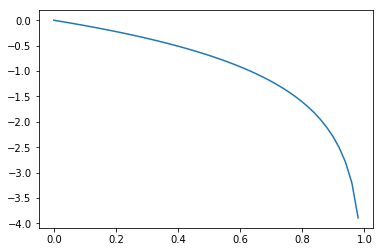

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


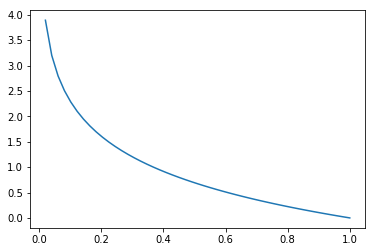

In [12]:
plt.plot(np.linspace(0,1),np.log(1-np.linspace(0,1)))
plt.show()
plt.plot(np.linspace(0,1),-np.log(np.linspace(0,1)))
plt.show()

['Grace,', 'running', 'away', 'from', 'home', 'to', 'marry', 'Abraham,', 'arrives', 'in', 'an', 'exhausted', 'condition', 'at', 'the', 'church', 'where', 'she', 'is', 'to', 'meet', 'Abraham.', 'Scarcely', 'realizing', 'what', 'is', 'going', 'on,', 'she', 'is', 'married', 'to', 'a', 'man', 'who,', 'as', 'her', 'senses', 'clear,', 'she', 'discovers', 'is', 'not', 'Abraham', 'but', 'AX', '.', 'She', 'swoons', 'on', 'making', 'the', 'discovery,', 'and', 'AX', 'disappears']

0.3520374894142151

['AX,', 'a', 'gay', 'young', 'blade', 'traveling', 'through', 'the', 'country,', 'takes', 'refuge', 'from', 'a', 'storm', 'in', 'a', 'rural', 'church.', 'To', 'his', 'astonishment,', 'he', 'is', 'hailed', 'at', 'once', 'as', 'a', 'bridegroom,', 'and', 'is', 'hurried', 'to', 'the', 'altar', 'where', 'a', 'pretty', 'girl,', 'Justin', 'in', 'an', 'exhausted', 'condition,', 'seems', 'waiting', 'for', 'him.', 'In', 'a', 'spirit', 'of', 'recklessness', ',', 'he', 'allows', 'himself', 'to', 'be', 'married', 'to', 'her;', 'and', 'when', 'she,', 'after', 'the', 'ceremony,', 'seems', 'to', 'realize', 'that', 'he', 'is', 'not', 'the', 'man', 'she', 'thought', 'he', 'was,', 'he', 'hurriedly', 'makes', 'his', 'escape']



['Gabriela,', 'carrying', 'the', 'news', 'of', 'the', 'death', 'of', 'his', 'friend,', 'Abigail,', 'to', 'Kathryn,', 'the', 'girl', 'to', 'whom', 'Abigail', 'was', 'betrothed,', ',', 'is', 'mistaken', 'by', 'Kathryn', 'and', 'her', 'parents', 'for', 'Abigail.', 'Kathryn', 'and', 'her', 'parents', 'have', 'never', 'seen', 'Abigail', 'or', 'Gabriela', '', 'Gabriela,', 'posing', 'as', 'his', 'dead', 'friend,', 'Abigail,', 'falls', 'in', 'love', 'with', 'Kathryn,', 'and', 'withholds', 'the', 'news', 'of', "Abigail's", 'death', '*']

0.31752461194992065

['Liliana', 'is', 'impelled', 'by', 'an', 'unusual', 'motive', 'to', 'marry', 'Nathan,', 'a', 'woman', 'he', 'does', 'not', 'love', '', 'Liliana', 'succeeds', 'by', 'a', 'stratagem', 'in', 'leaving', 'his', 'unloved', 'wife,', 'Nathan', 'and,', 'under', 'a', 'fictitious', 'name,', 'marries', 'Christina,', 'the', 'woman', 'he', 'loves', '*']